In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "100X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 3


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_100X-BREAKHIS-Dataset-60-10-30-VGGINet/3'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/100X/3'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1128 files belonging to 2 classes.


Found 187 files belonging to 2 classes.


Found 566 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4328 - accuracy: 0.5000

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 6.8538 - accuracy: 0.5898

3/9 [=========>....................] - ETA: 4s - loss: 6.0283 - accuracy: 0.6589

4/9 [============>.................] - ETA: 7s - loss: 5.2543 - accuracy: 0.6973

5/9 [===============>..............] - ETA: 6s - loss: 5.4658 - accuracy: 0.6812

6/9 [===================>..........] - ETA: 4s - loss: 5.0716 - accuracy: 0.6810

7/9 [======================>.......] - ETA: 2s - loss: 4.6293 - accuracy: 0.7109

8/9 [=========================>....] - ETA: 1s - loss: 4.2648 - accuracy: 0.7334

9/9 [==============================] - ETA: 0s - loss: 4.0758 - accuracy: 0.7473

9/9 [==============================] - 28s 3s/step - loss: 4.0758 - accuracy: 0.7473 - val_loss: 4.4561 - val_accuracy: 0.8930


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 4.4174 - accuracy: 0.8203

2/9 [=====>........................] - ETA: 16s - loss: 3.1661 - accuracy: 0.8672

3/9 [=========>....................] - ETA: 11s - loss: 2.6300 - accuracy: 0.8802

4/9 [============>.................] - ETA: 11s - loss: 2.8253 - accuracy: 0.8750

5/9 [===============>..............] - ETA: 8s - loss: 2.5114 - accuracy: 0.8734 

6/9 [===================>..........] - ETA: 5s - loss: 2.5735 - accuracy: 0.8633

7/9 [======================>.......] - ETA: 3s - loss: 2.4758 - accuracy: 0.8683

8/9 [=========================>....] - ETA: 1s - loss: 2.3544 - accuracy: 0.8711

9/9 [==============================] - ETA: 0s - loss: 2.2719 - accuracy: 0.8741

9/9 [==============================] - 17s 2s/step - loss: 2.2719 - accuracy: 0.8741 - val_loss: 2.5759 - val_accuracy: 0.8930


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 2.9299 - accuracy: 0.7422

2/9 [=====>........................] - ETA: 10s - loss: 2.6219 - accuracy: 0.7812

3/9 [=========>....................] - ETA: 8s - loss: 2.2634 - accuracy: 0.8151 

4/9 [============>.................] - ETA: 8s - loss: 2.0343 - accuracy: 0.8359

5/9 [===============>..............] - ETA: 7s - loss: 1.8543 - accuracy: 0.8531

6/9 [===================>..........] - ETA: 4s - loss: 1.9623 - accuracy: 0.8503

7/9 [======================>.......] - ETA: 3s - loss: 2.1472 - accuracy: 0.8482

8/9 [=========================>....] - ETA: 1s - loss: 2.3271 - accuracy: 0.8438

9/9 [==============================] - ETA: 0s - loss: 2.1859 - accuracy: 0.8502

9/9 [==============================] - 16s 2s/step - loss: 2.1859 - accuracy: 0.8502 - val_loss: 2.9294 - val_accuracy: 0.8930


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2540 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 1.4657 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 9s - loss: 1.4516 - accuracy: 0.8880 

4/9 [============>.................] - ETA: 9s - loss: 1.6050 - accuracy: 0.8828

5/9 [===============>..............] - ETA: 6s - loss: 1.4788 - accuracy: 0.8891

6/9 [===================>..........] - ETA: 4s - loss: 1.6085 - accuracy: 0.8854

7/9 [======================>.......] - ETA: 3s - loss: 1.5503 - accuracy: 0.8850

8/9 [=========================>....] - ETA: 1s - loss: 1.6144 - accuracy: 0.8838

9/9 [==============================] - ETA: 0s - loss: 1.5809 - accuracy: 0.8856

9/9 [==============================] - 16s 2s/step - loss: 1.5809 - accuracy: 0.8856 - val_loss: 1.9517 - val_accuracy: 0.9305


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1353 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 13s - loss: 1.6354 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 9s - loss: 1.3411 - accuracy: 0.9036 

4/9 [============>.................] - ETA: 9s - loss: 1.5694 - accuracy: 0.8906

5/9 [===============>..............] - ETA: 7s - loss: 1.5551 - accuracy: 0.8891

6/9 [===================>..........] - ETA: 4s - loss: 1.4511 - accuracy: 0.8932

7/9 [======================>.......] - ETA: 3s - loss: 1.4224 - accuracy: 0.8951

8/9 [=========================>....] - ETA: 1s - loss: 1.3555 - accuracy: 0.8975

9/9 [==============================] - ETA: 0s - loss: 1.3060 - accuracy: 0.8972

9/9 [==============================] - 16s 2s/step - loss: 1.3060 - accuracy: 0.8972 - val_loss: 1.7670 - val_accuracy: 0.9465


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0446 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 12s - loss: 0.6667 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.6496 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 9s - loss: 0.9966 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 7s - loss: 1.0641 - accuracy: 0.9141

6/9 [===================>..........] - ETA: 5s - loss: 0.9641 - accuracy: 0.9128

7/9 [======================>.......] - ETA: 3s - loss: 0.9124 - accuracy: 0.9196

8/9 [=========================>....] - ETA: 1s - loss: 0.9813 - accuracy: 0.9199

9/9 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.9193

9/9 [==============================] - 16s 2s/step - loss: 0.9922 - accuracy: 0.9193 - val_loss: 2.3758 - val_accuracy: 0.9198


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1227 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 3s - loss: 1.4643 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 7s - loss: 1.1295 - accuracy: 0.9141

4/9 [============>.................] - ETA: 6s - loss: 1.1938 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 6s - loss: 1.0783 - accuracy: 0.9187

6/9 [===================>..........] - ETA: 4s - loss: 1.0074 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 2s - loss: 1.1255 - accuracy: 0.9062

8/9 [=========================>....] - ETA: 1s - loss: 1.2559 - accuracy: 0.8965

9/9 [==============================] - ETA: 0s - loss: 1.2502 - accuracy: 0.8989

9/9 [==============================] - 15s 2s/step - loss: 1.2502 - accuracy: 0.8989 - val_loss: 1.4096 - val_accuracy: 0.9358


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5865 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.7164 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 7s - loss: 0.8873 - accuracy: 0.9297

4/9 [============>.................] - ETA: 6s - loss: 1.1580 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 6s - loss: 1.2893 - accuracy: 0.9109

6/9 [===================>..........] - ETA: 5s - loss: 1.2860 - accuracy: 0.9128

7/9 [======================>.......] - ETA: 3s - loss: 1.3335 - accuracy: 0.9096

8/9 [=========================>....] - ETA: 1s - loss: 1.2407 - accuracy: 0.9131

9/9 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.9122

9/9 [==============================] - 16s 2s/step - loss: 1.2323 - accuracy: 0.9122 - val_loss: 1.6043 - val_accuracy: 0.9198


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1664 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 13s - loss: 0.7902 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 0.8949 - accuracy: 0.9089 

4/9 [============>.................] - ETA: 9s - loss: 0.8435 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 7s - loss: 0.9089 - accuracy: 0.9141

6/9 [===================>..........] - ETA: 4s - loss: 1.1265 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 1.1678 - accuracy: 0.9074

8/9 [=========================>....] - ETA: 1s - loss: 1.1581 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.9060

9/9 [==============================] - 16s 2s/step - loss: 1.2183 - accuracy: 0.9060 - val_loss: 1.2694 - val_accuracy: 0.9358


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4427 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 9s - loss: 0.8974 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 8s - loss: 0.8916 - accuracy: 0.9375

4/9 [============>.................] - ETA: 8s - loss: 0.8192 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 6s - loss: 0.8953 - accuracy: 0.9266

6/9 [===================>..........] - ETA: 4s - loss: 0.8720 - accuracy: 0.9271

7/9 [======================>.......] - ETA: 2s - loss: 1.0023 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 0.9662 - accuracy: 0.9180

9/9 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.9140

9/9 [==============================] - 15s 2s/step - loss: 0.9839 - accuracy: 0.9140 - val_loss: 1.2213 - val_accuracy: 0.9412


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5059 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.3694 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.6533 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.8573 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.8585 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.8421 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.9058 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.9785 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.9211

9/9 [==============================] - 16s 2s/step - loss: 1.0026 - accuracy: 0.9211 - val_loss: 1.3764 - val_accuracy: 0.9358


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9642 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 1.0522 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 15s - loss: 1.2228 - accuracy: 0.9010

4/9 [============>.................] - ETA: 10s - loss: 1.3778 - accuracy: 0.8867

5/9 [===============>..............] - ETA: 7s - loss: 1.2158 - accuracy: 0.8953 

6/9 [===================>..........] - ETA: 5s - loss: 1.1042 - accuracy: 0.9023

7/9 [======================>.......] - ETA: 3s - loss: 1.0913 - accuracy: 0.9051

8/9 [=========================>....] - ETA: 1s - loss: 1.0922 - accuracy: 0.9072

9/9 [==============================] - ETA: 0s - loss: 1.1272 - accuracy: 0.9034

9/9 [==============================] - 17s 2s/step - loss: 1.1272 - accuracy: 0.9034 - val_loss: 0.6395 - val_accuracy: 0.9519


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7429 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 13s - loss: 1.2685 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 1.0865 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 10s - loss: 0.9552 - accuracy: 0.9199

5/9 [===============>..............] - ETA: 7s - loss: 0.8644 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 0.8627 - accuracy: 0.9271

7/9 [======================>.......] - ETA: 3s - loss: 0.8982 - accuracy: 0.9275

8/9 [=========================>....] - ETA: 1s - loss: 0.8541 - accuracy: 0.9307

9/9 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.9291

9/9 [==============================] - 16s 2s/step - loss: 0.8825 - accuracy: 0.9291 - val_loss: 1.1177 - val_accuracy: 0.9358


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3940 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.3940 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.5722 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.6325 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.6680 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 4s - loss: 0.6457 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.7052 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.7637 - accuracy: 0.9336

9/9 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.9344

9/9 [==============================] - 16s 2s/step - loss: 0.7560 - accuracy: 0.9344 - val_loss: 1.6044 - val_accuracy: 0.9198


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5341 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 12s - loss: 0.7085 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.8028 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 9s - loss: 1.0136 - accuracy: 0.9199

5/9 [===============>..............] - ETA: 6s - loss: 1.0992 - accuracy: 0.9125

6/9 [===================>..........] - ETA: 4s - loss: 1.2141 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 2s - loss: 1.1890 - accuracy: 0.9107

8/9 [=========================>....] - ETA: 1s - loss: 1.1537 - accuracy: 0.9150

9/9 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.9158

9/9 [==============================] - 15s 2s/step - loss: 1.2052 - accuracy: 0.9158 - val_loss: 0.1953 - val_accuracy: 0.9679


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5084 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 1.4486 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 1.1812 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 7s - loss: 1.1942 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 1.0559 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 5s - loss: 1.1127 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.9899 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.9834 - accuracy: 0.9375

9/9 [==============================] - ETA: 0s - loss: 0.9375 - accuracy: 0.9379

9/9 [==============================] - 16s 2s/step - loss: 0.9375 - accuracy: 0.9379 - val_loss: 0.9094 - val_accuracy: 0.9519


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6744 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6156 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.9825 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 9s - loss: 0.9209 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.9410 - accuracy: 0.9266

6/9 [===================>..........] - ETA: 5s - loss: 0.8721 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 3s - loss: 0.8066 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.8220 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.9362

9/9 [==============================] - 17s 2s/step - loss: 0.8211 - accuracy: 0.9362 - val_loss: 0.9447 - val_accuracy: 0.9626


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3469 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4356 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.6272 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6096 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.5234 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.6091 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5664 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5445 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.9441

9/9 [==============================] - 16s 2s/step - loss: 0.5871 - accuracy: 0.9441 - val_loss: 1.0995 - val_accuracy: 0.9572


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1987 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 1.2867 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 1.0923 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 10s - loss: 1.1216 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 1.0904 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 1.0513 - accuracy: 0.9245

7/9 [======================>.......] - ETA: 3s - loss: 0.9470 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.9725 - accuracy: 0.9307

9/9 [==============================] - ETA: 0s - loss: 0.9468 - accuracy: 0.9309

9/9 [==============================] - 16s 2s/step - loss: 0.9468 - accuracy: 0.9309 - val_loss: 0.7214 - val_accuracy: 0.9412


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3744 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.6133 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.4849 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 10s - loss: 0.5087 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.5921 - accuracy: 0.9422 

6/9 [===================>..........] - ETA: 5s - loss: 0.6795 - accuracy: 0.9362

7/9 [======================>.......] - ETA: 3s - loss: 0.7127 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.9371

9/9 [==============================] - 16s 2s/step - loss: 0.7025 - accuracy: 0.9371 - val_loss: 0.5821 - val_accuracy: 0.9572


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2172 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4929 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.5506 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 7s - loss: 0.5342 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.5770 - accuracy: 0.9438

6/9 [===================>..........] - ETA: 5s - loss: 0.6142 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.6041 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.5879 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.9441

9/9 [==============================] - 16s 2s/step - loss: 0.6335 - accuracy: 0.9441 - val_loss: 0.3184 - val_accuracy: 0.9626


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7946 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5095 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 15s - loss: 0.4193 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.5510 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.5106 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.5691 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.5791 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5424 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.9512

9/9 [==============================] - 17s 2s/step - loss: 0.5478 - accuracy: 0.9512 - val_loss: 0.6130 - val_accuracy: 0.9572


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5349 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8710 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7860 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.8743 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.8309 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 5s - loss: 0.8840 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.8137 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.7261 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.9459

9/9 [==============================] - 17s 2s/step - loss: 0.7346 - accuracy: 0.9459 - val_loss: 1.0316 - val_accuracy: 0.9358


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2134 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2649 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.4157 - accuracy: 0.9531 

4/9 [============>.................] - ETA: 9s - loss: 0.4397 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.4212 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 5s - loss: 0.5422 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5157 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5333 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.9504

9/9 [==============================] - 16s 2s/step - loss: 0.5133 - accuracy: 0.9504 - val_loss: 1.0651 - val_accuracy: 0.9465


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3724 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.2537 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 7s - loss: 0.3639 - accuracy: 0.9583

4/9 [============>.................] - ETA: 6s - loss: 0.5502 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.5502 - accuracy: 0.9500

6/9 [===================>..........] - ETA: 4s - loss: 0.6354 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.6381 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.9441

9/9 [==============================] - 16s 2s/step - loss: 0.6691 - accuracy: 0.9441 - val_loss: 0.9844 - val_accuracy: 0.9358


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2153 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.2316 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 7s - loss: 0.5607 - accuracy: 0.9505

4/9 [============>.................] - ETA: 6s - loss: 0.4643 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 6s - loss: 0.5133 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.4933 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 2s - loss: 0.4864 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.5226 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.9548

9/9 [==============================] - 15s 2s/step - loss: 0.5450 - accuracy: 0.9548 - val_loss: 0.5840 - val_accuracy: 0.9412


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1674 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 4s - loss: 0.7831 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 8s - loss: 0.6708 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.5577 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.5784 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.5879 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5844 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.5662 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9592

9/9 [==============================] - 16s 2s/step - loss: 0.5519 - accuracy: 0.9592 - val_loss: 0.4459 - val_accuracy: 0.9626


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2637 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3017 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.2769 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.2909 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3964 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.4555 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4463 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.4791 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.9557

9/9 [==============================] - 16s 2s/step - loss: 0.4931 - accuracy: 0.9557 - val_loss: 0.2355 - val_accuracy: 0.9626


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5966 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.6142 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.7259 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.6742 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 6s - loss: 0.6424 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 4s - loss: 0.5710 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.5263 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.5657 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.9450

9/9 [==============================] - 16s 2s/step - loss: 0.5758 - accuracy: 0.9450 - val_loss: 0.7273 - val_accuracy: 0.9679


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3470 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.1868 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.1905 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2048 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.2039 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.2339 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.2685 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.2546 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.2682 - accuracy: 0.9690 - val_loss: 0.5724 - val_accuracy: 0.9465


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3415 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3944 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 15s - loss: 0.6642 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.7206 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.6796 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 5s - loss: 0.6160 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.5948 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.5915 - accuracy: 0.9441

9/9 [==============================] - 16s 2s/step - loss: 0.5915 - accuracy: 0.9441 - val_loss: 0.3641 - val_accuracy: 0.9572


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2658 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3118 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2557 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.2383 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3690 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.5213 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5765 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.6458 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.9468

9/9 [==============================] - 16s 2s/step - loss: 0.6316 - accuracy: 0.9468 - val_loss: 0.2197 - val_accuracy: 0.9893


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2743 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5669 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.6056 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.6645 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.6305 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 4s - loss: 0.5757 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5313 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5435 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.9539

9/9 [==============================] - 16s 2s/step - loss: 0.5654 - accuracy: 0.9539 - val_loss: 0.3253 - val_accuracy: 0.9626


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4403 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 1.0360 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.8972 - accuracy: 0.9427

4/9 [============>.................] - ETA: 10s - loss: 0.8112 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.6664 - accuracy: 0.9500 

6/9 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6665 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.9504

9/9 [==============================] - 16s 2s/step - loss: 0.6091 - accuracy: 0.9504 - val_loss: 0.2964 - val_accuracy: 0.9786


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7179 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5491 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.6617 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 10s - loss: 0.5764 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.5604 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.5363 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.4951 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.5236 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.9512

9/9 [==============================] - 16s 2s/step - loss: 0.5061 - accuracy: 0.9512 - val_loss: 0.7828 - val_accuracy: 0.9519


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4679 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8470 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 15s - loss: 0.7096 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.6850 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6493 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.7024 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.7003 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.9530

9/9 [==============================] - 16s 2s/step - loss: 0.6570 - accuracy: 0.9530 - val_loss: 0.3746 - val_accuracy: 0.9733


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8788 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.8143 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 7s - loss: 0.7031 - accuracy: 0.9661

4/9 [============>.................] - ETA: 6s - loss: 0.6779 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 6s - loss: 0.6384 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.6132 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 2s - loss: 0.5419 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.6277 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.9601

9/9 [==============================] - 15s 2s/step - loss: 0.6388 - accuracy: 0.9601 - val_loss: 0.3538 - val_accuracy: 0.9786


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4333 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5183 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.4125 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5254 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.5200 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.4338 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3734 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3928 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.9672

9/9 [==============================] - 16s 2s/step - loss: 0.4604 - accuracy: 0.9672 - val_loss: 0.3277 - val_accuracy: 0.9786


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2978 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.2889 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4581 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.6804 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6206 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5976 - accuracy: 0.9580

9/9 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.9557

9/9 [==============================] - 16s 2s/step - loss: 0.6307 - accuracy: 0.9557 - val_loss: 0.3478 - val_accuracy: 0.9679


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2475 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3090 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3317 - accuracy: 0.9635

4/9 [============>.................] - ETA: 10s - loss: 0.3588 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4418 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.4363 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4787 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.4432 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.9601

9/9 [==============================] - 16s 2s/step - loss: 0.4544 - accuracy: 0.9601 - val_loss: 0.1958 - val_accuracy: 0.9733


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6702 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5667 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.5622 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 10s - loss: 0.5044 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4190 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.3562 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3376 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3616 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9663

9/9 [==============================] - 16s 2s/step - loss: 0.3538 - accuracy: 0.9663 - val_loss: 0.2693 - val_accuracy: 0.9786


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3633 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.5973 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.4501 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.4395 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5129 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.7112 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.6678 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5990 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.9628

9/9 [==============================] - 16s 2s/step - loss: 0.5776 - accuracy: 0.9628 - val_loss: 0.2648 - val_accuracy: 0.9733


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5783 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.3379 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.2577 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.2948 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3325 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 4s - loss: 0.3709 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3981 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3753 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.3939 - accuracy: 0.9690 - val_loss: 0.0546 - val_accuracy: 0.9893


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5168 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.7984 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.6198 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.6729 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.6966 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.6743 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.6661 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.6120 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.9645

9/9 [==============================] - 16s 2s/step - loss: 0.6404 - accuracy: 0.9645 - val_loss: 0.3194 - val_accuracy: 0.9626


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1314 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.5822 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.5882 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.6294 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.5827 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.5578 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.6253 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.9637

9/9 [==============================] - 17s 2s/step - loss: 0.5786 - accuracy: 0.9637 - val_loss: 0.4262 - val_accuracy: 0.9679


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7033 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5218 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 15s - loss: 0.4527 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3827 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4372 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.6006 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5436 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5313 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.9654

9/9 [==============================] - 17s 2s/step - loss: 0.5065 - accuracy: 0.9654 - val_loss: 0.5883 - val_accuracy: 0.9733


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3810 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.4048 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.3132 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3658 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3297 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4233 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.4317 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4335 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.9654

9/9 [==============================] - 16s 2s/step - loss: 0.4430 - accuracy: 0.9654 - val_loss: 0.5600 - val_accuracy: 0.9626


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1722 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 5s - loss: 0.5751 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 8s - loss: 0.5319 - accuracy: 0.9635

4/9 [============>.................] - ETA: 6s - loss: 0.4247 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 6s - loss: 0.5408 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.5298 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 2s - loss: 0.5945 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.5664 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.9566

9/9 [==============================] - 15s 2s/step - loss: 0.5660 - accuracy: 0.9566 - val_loss: 0.5465 - val_accuracy: 0.9465


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2846 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4028 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3533 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3048 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.3052 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2623 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2549 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2528 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.2760 - accuracy: 0.9796 - val_loss: 1.5422 - val_accuracy: 0.9358


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4222 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.4027 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3498 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.3229 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4402 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.4272 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4093 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4073 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.9663

9/9 [==============================] - 16s 2s/step - loss: 0.3947 - accuracy: 0.9663 - val_loss: 1.1608 - val_accuracy: 0.9198


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1320 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4060 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.6689 - accuracy: 0.9505

4/9 [============>.................] - ETA: 10s - loss: 0.7323 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.7363 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.7137 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.7085 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.9539

9/9 [==============================] - 16s 2s/step - loss: 0.7251 - accuracy: 0.9539 - val_loss: 0.1739 - val_accuracy: 0.9733


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9637 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 18s - loss: 0.6991 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 12s - loss: 0.5041 - accuracy: 0.9635

4/9 [============>.................] - ETA: 13s - loss: 0.4979 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 9s - loss: 0.4999 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 6s - loss: 0.4897 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5318 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5389 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.9645

9/9 [==============================] - 19s 2s/step - loss: 0.5164 - accuracy: 0.9645 - val_loss: 0.5403 - val_accuracy: 0.9679


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3253 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.5962 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.4417 - accuracy: 0.9609

4/9 [============>.................] - ETA: 7s - loss: 0.3586 - accuracy: 0.9629 

5/9 [===============>..............] - ETA: 8s - loss: 0.3998 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 5s - loss: 0.3831 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.3831 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.3891 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.9637

9/9 [==============================] - 18s 2s/step - loss: 0.3888 - accuracy: 0.9637 - val_loss: 0.1672 - val_accuracy: 0.9733


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2396 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.5632 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.4405 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4426 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4888 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4345 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4421 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4133 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.9681

9/9 [==============================] - 17s 2s/step - loss: 0.3884 - accuracy: 0.9681 - val_loss: 0.5921 - val_accuracy: 0.9679


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2955 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.2517 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.4052 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3990 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4025 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3644 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3253 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3243 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.9681

9/9 [==============================] - 17s 2s/step - loss: 0.3963 - accuracy: 0.9681 - val_loss: 0.5519 - val_accuracy: 0.9626


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2426 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2033 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2956 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.2609 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.2987 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.3052 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.3144 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3303 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.9743

9/9 [==============================] - 17s 2s/step - loss: 0.3141 - accuracy: 0.9743 - val_loss: 0.4611 - val_accuracy: 0.9733


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1457 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 16s - loss: 0.2935 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 11s - loss: 0.3558 - accuracy: 0.9740

4/9 [============>.................] - ETA: 11s - loss: 0.3766 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.4039 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4306 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4848 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.5057 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.9663

9/9 [==============================] - 18s 2s/step - loss: 0.4909 - accuracy: 0.9663 - val_loss: 0.3372 - val_accuracy: 0.9840


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4055 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.3179 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 11s - loss: 0.4001 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4454 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4063 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4035 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4141 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4423 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.9707

9/9 [==============================] - 17s 2s/step - loss: 0.4015 - accuracy: 0.9707 - val_loss: 0.5150 - val_accuracy: 0.9519


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2951 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 18s - loss: 0.1915 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 17s - loss: 0.2920 - accuracy: 0.9714

4/9 [============>.................] - ETA: 12s - loss: 0.3084 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.2530 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3370 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3349 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3509 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.9725

9/9 [==============================] - 18s 2s/step - loss: 0.3696 - accuracy: 0.9725 - val_loss: 0.7600 - val_accuracy: 0.9465


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2394 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 16s - loss: 0.1321 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 11s - loss: 0.3064 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.2373 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.1907 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.3186 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.2874 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2664 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.9707

9/9 [==============================] - 17s 2s/step - loss: 0.3226 - accuracy: 0.9707 - val_loss: 0.2378 - val_accuracy: 0.9840


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4599 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2383 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3855 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.4274 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3829 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3927 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3599 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3399 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.3851 - accuracy: 0.9725 - val_loss: 0.5949 - val_accuracy: 0.9733


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5432 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5160 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.6318 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.5052 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 8s - loss: 0.4393 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4963 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4613 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.4242 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.9707

9/9 [==============================] - 18s 2s/step - loss: 0.4344 - accuracy: 0.9707 - val_loss: 0.2128 - val_accuracy: 0.9786


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4119 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.3857 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2925 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2727 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.3239 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4046 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3922 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3636 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.9716

9/9 [==============================] - 18s 2s/step - loss: 0.4059 - accuracy: 0.9716 - val_loss: 1.3467 - val_accuracy: 0.9412


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3826 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.3827 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4323 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.4271 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3718 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3796 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3515 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3666 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.9778

9/9 [==============================] - 17s 2s/step - loss: 0.3635 - accuracy: 0.9778 - val_loss: 1.0563 - val_accuracy: 0.9626


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2089 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.2329 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.3514 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.2747 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3203 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2973 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3158 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2929 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.2810 - accuracy: 0.9752 - val_loss: 0.4451 - val_accuracy: 0.9733


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5393 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 15s - loss: 0.3362 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4003 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3131 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2505 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3553 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3684 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3441 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.9734

9/9 [==============================] - 17s 2s/step - loss: 0.3593 - accuracy: 0.9734 - val_loss: 0.9289 - val_accuracy: 0.9572


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2511 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.4222 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4349 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.7122 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.6253 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.6150 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.5271 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.5864 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.9699

9/9 [==============================] - 17s 2s/step - loss: 0.5373 - accuracy: 0.9699 - val_loss: 0.8505 - val_accuracy: 0.9679


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6218 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 15s - loss: 0.3110 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2079 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1569 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1743 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2160 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2825 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3098 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.9778

9/9 [==============================] - 17s 2s/step - loss: 0.2956 - accuracy: 0.9778 - val_loss: 1.2802 - val_accuracy: 0.9412


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2275 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.1228 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2883 - accuracy: 0.9740

4/9 [============>.................] - ETA: 6s - loss: 0.2761 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.5288 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.6314 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 2s - loss: 0.5657 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5243 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.9681

9/9 [==============================] - 16s 2s/step - loss: 0.5031 - accuracy: 0.9681 - val_loss: 0.9370 - val_accuracy: 0.9519


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 16s - loss: 0.3089 - accuracy: 0.9766

4/9 [============>.................] - ETA: 13s - loss: 0.3453 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 9s - loss: 0.3430 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 6s - loss: 0.3523 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 4s - loss: 0.3363 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3894 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.9699

9/9 [==============================] - 19s 2s/step - loss: 0.4509 - accuracy: 0.9699 - val_loss: 1.0758 - val_accuracy: 0.9412


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6622 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4006 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2945 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.4541 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.4291 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.4231 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.5413 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4919 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.9690

9/9 [==============================] - 16s 2s/step - loss: 0.5499 - accuracy: 0.9690 - val_loss: 0.9832 - val_accuracy: 0.9519


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.1660 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 7s - loss: 0.2567 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2730 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3759 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3665 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3485 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.9725

9/9 [==============================] - 17s 2s/step - loss: 0.3704 - accuracy: 0.9725 - val_loss: 1.3017 - val_accuracy: 0.9572


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2572 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2030 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1933 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.2485 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2877 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.4770 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4923 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.5179 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.4900 - accuracy: 0.9699 - val_loss: 0.3840 - val_accuracy: 0.9733


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3788 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3181 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.5092 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.4039 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3231 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.4265 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.4801 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.5289 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.9699

9/9 [==============================] - 16s 2s/step - loss: 0.5431 - accuracy: 0.9699 - val_loss: 0.6217 - val_accuracy: 0.9733


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2897 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.2847 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4874 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4161 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.3979 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.3521 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3250 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2875 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2660 - accuracy: 0.9778 - val_loss: 0.9676 - val_accuracy: 0.9733


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2608 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.2408 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.3096 - accuracy: 0.9688

4/9 [============>.................] - ETA: 6s - loss: 0.2372 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2125 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2114 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.1846 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2831 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.9743

9/9 [==============================] - 16s 2s/step - loss: 0.3507 - accuracy: 0.9743 - val_loss: 1.2049 - val_accuracy: 0.9572


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1995 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.6140 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4230 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3226 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3120 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2868 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2596 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3058 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3085 - accuracy: 0.9796 - val_loss: 0.7725 - val_accuracy: 0.9572


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2726 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3993 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4353 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.4790 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4066 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.4130 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3542 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3928 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3566 - accuracy: 0.9752 - val_loss: 0.8072 - val_accuracy: 0.9679


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4584e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9961    

3/9 [=========>....................] - ETA: 7s - loss: 0.4312 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.3543 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.3138 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.3367 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 2s - loss: 0.3904 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3594 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.9787

9/9 [==============================] - 15s 2s/step - loss: 0.3559 - accuracy: 0.9787 - val_loss: 0.9175 - val_accuracy: 0.9733


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1486 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.0929 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 11s - loss: 0.1855 - accuracy: 0.9792

4/9 [============>.................] - ETA: 8s - loss: 0.3023 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 5s - loss: 0.3000 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.2924 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 2s - loss: 0.3001 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.2644 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.9734

9/9 [==============================] - 14s 2s/step - loss: 0.2823 - accuracy: 0.9734 - val_loss: 0.2559 - val_accuracy: 0.9840


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.3525 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4073 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3055 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.3480 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3317 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2844 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2646 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9849

9/9 [==============================] - 17s 2s/step - loss: 0.2484 - accuracy: 0.9849 - val_loss: 0.1817 - val_accuracy: 0.9786


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4379 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3612 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3186 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.2725 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.2400 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.2205 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.1991 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.1892 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9778

9/9 [==============================] - 16s 2s/step - loss: 0.2451 - accuracy: 0.9778 - val_loss: 1.0588 - val_accuracy: 0.9519


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3516 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.5546 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 16s - loss: 0.4207 - accuracy: 0.9766

4/9 [============>.................] - ETA: 15s - loss: 0.3632 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 10s - loss: 0.3546 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 7s - loss: 0.3013 - accuracy: 0.9779 

7/9 [======================>.......] - ETA: 4s - loss: 0.3248 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 2s - loss: 0.3393 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.9743

9/9 [==============================] - 21s 2s/step - loss: 0.3632 - accuracy: 0.9743 - val_loss: 0.3409 - val_accuracy: 0.9840


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0533 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0849 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0573 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0799 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1038 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1354 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1327 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1315 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.1220 - accuracy: 0.9840 - val_loss: 0.5371 - val_accuracy: 0.9786


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1916 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.2269 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3281 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3367 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2902 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2688 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2327 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2918 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.9787

9/9 [==============================] - 17s 2s/step - loss: 0.2674 - accuracy: 0.9787 - val_loss: 0.4477 - val_accuracy: 0.9786


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2177 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 15s - loss: 0.5348 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4042 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3035 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2970 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2527 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2763 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3498 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.9849

9/9 [==============================] - 17s 2s/step - loss: 0.3175 - accuracy: 0.9849 - val_loss: 0.4144 - val_accuracy: 0.9733


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 9.7225e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0242 - accuracy: 0.9961    

3/9 [=========>....................] - ETA: 8s - loss: 0.1840 - accuracy: 0.9922

4/9 [============>.................] - ETA: 6s - loss: 0.1914 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 6s - loss: 0.1550 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.1822 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 2s - loss: 0.2474 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2494 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9876

9/9 [==============================] - 16s 2s/step - loss: 0.2265 - accuracy: 0.9876 - val_loss: 0.3422 - val_accuracy: 0.9733


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1062 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 11s - loss: 0.1436 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1544 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1398 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1267 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1088 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1997 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9814

9/9 [==============================] - 17s 2s/step - loss: 0.2096 - accuracy: 0.9814 - val_loss: 0.0723 - val_accuracy: 0.9893


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1267 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1534 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.4960 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.4432 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 8s - loss: 0.4304 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.3703 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3206 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3315 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.9761

9/9 [==============================] - 17s 2s/step - loss: 0.3216 - accuracy: 0.9761 - val_loss: 0.0042 - val_accuracy: 0.9947


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 5.4662e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.1490 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.1982 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.4432 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.4973 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.4416 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3847 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.3375 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3621 - accuracy: 0.9849

9/9 [==============================] - 17s 2s/step - loss: 0.3621 - accuracy: 0.9849 - val_loss: 0.0033 - val_accuracy: 1.0000


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2585 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.1757 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2022 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.3489 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2929 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2972 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3049 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3020 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9805

9/9 [==============================] - 17s 2s/step - loss: 0.2796 - accuracy: 0.9805 - val_loss: 0.6348 - val_accuracy: 0.9733


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0690 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.5557 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4353 - accuracy: 0.9844

4/9 [============>.................] - ETA: 7s - loss: 0.3315 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 8s - loss: 0.3060 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.4175 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.4196 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3733 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.9778

9/9 [==============================] - 17s 2s/step - loss: 0.3906 - accuracy: 0.9778 - val_loss: 0.0490 - val_accuracy: 0.9893


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1241 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1906 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1464 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1219 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2278 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2021 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2270 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2354 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9885

9/9 [==============================] - 17s 2s/step - loss: 0.2137 - accuracy: 0.9885 - val_loss: 0.2022 - val_accuracy: 0.9893


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.0433 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0992 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0744 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.0946 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0792 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1073 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1509 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9894

9/9 [==============================] - 17s 2s/step - loss: 0.1474 - accuracy: 0.9894 - val_loss: 0.1647 - val_accuracy: 0.9893


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3287 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2033 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1456 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2192 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2430 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2122 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.1960 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1715 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9840

9/9 [==============================] - 17s 2s/step - loss: 0.2095 - accuracy: 0.9840 - val_loss: 0.0198 - val_accuracy: 0.9893


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0811 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 7s - loss: 0.1328 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.1654 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2100 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.1751 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1855 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1703 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9894

9/9 [==============================] - 16s 2s/step - loss: 0.1547 - accuracy: 0.9894 - val_loss: 0.3352 - val_accuracy: 0.9893


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2321 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.3461 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 10s - loss: 0.4878 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3929 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.4053 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3477 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3082 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.9832

9/9 [==============================] - 16s 2s/step - loss: 0.3020 - accuracy: 0.9832 - val_loss: 0.0965 - val_accuracy: 0.9840


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8908 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4930 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.4544 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.4100 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.4036 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3892 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3365 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3076 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.9787

9/9 [==============================] - 16s 2s/step - loss: 0.2978 - accuracy: 0.9787 - val_loss: 0.2280 - val_accuracy: 0.9733


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.4160 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3135 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2356 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2821 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2805 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2587 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2263 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9885

9/9 [==============================] - 16s 2s/step - loss: 0.2120 - accuracy: 0.9885 - val_loss: 0.1903 - val_accuracy: 0.9840


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5690 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3225 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2150 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.1986 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.1900 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 4s - loss: 0.2245 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1927 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2273 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9849

9/9 [==============================] - 16s 2s/step - loss: 0.2070 - accuracy: 0.9849 - val_loss: 0.2364 - val_accuracy: 0.9840


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.0668 - accuracy: 0.9375

2/5 [===========>..................] - ETA: 2s - loss: 3.0563 - accuracy: 0.9375

3/5 [=================>............] - ETA: 2s - loss: 2.2927 - accuracy: 0.9505

4/5 [=======================>......] - ETA: 1s - loss: 1.9336 - accuracy: 0.9590

5/5 [==============================] - ETA: 0s - loss: 1.9104 - accuracy: 0.9558

5/5 [==============================] - 11s 2s/step - loss: 1.9104 - accuracy: 0.9558


[1.9104232788085938, 0.9558303952217102]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

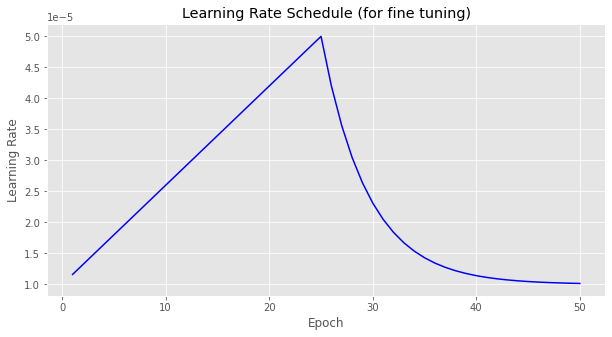

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1128 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/18 [>.............................] - ETA: 0s - loss: 1.1362e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 5s - loss: 1.0306e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 11s - loss: 7.4643e-06 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 12s - loss: 0.1445 - accuracy: 0.9883    

 5/18 [=======>......................] - ETA: 10s - loss: 0.1427 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 12s - loss: 0.1540 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 12s - loss: 0.1473 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 12s - loss: 0.1289 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 11s - loss: 0.1676 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 9s - loss: 0.1509 - accuracy: 0.9875 

11/18 [=================>............] - ETA: 8s - loss: 0.3412 - accuracy: 0.9815

12/18 [===================>..........] - ETA: 7s - loss: 0.3315 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.3060 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.3091 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.2887 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2706 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.2547 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9849

18/18 [==============================] - 27s 1s/step - loss: 0.2457 - accuracy: 0.9849 - val_loss: 0.1895 - val_accuracy: 0.9893



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/18 [>.............................] - ETA: 0s - loss: 3.8184e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 8s - loss: 0.0014 - accuracy: 1.0000    

 3/18 [====>.........................] - ETA: 14s - loss: 9.8658e-04 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9961    

 5/18 [=======>......................] - ETA: 15s - loss: 0.0697 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 14s - loss: 0.0595 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 17s - loss: 0.0510 - accuracy: 0.9978

 8/18 [============>.................] - ETA: 16s - loss: 0.0477 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 13s - loss: 0.0424 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 12s - loss: 0.0434 - accuracy: 0.9953

11/18 [=================>............] - ETA: 10s - loss: 0.0394 - accuracy: 0.9957

12/18 [===================>..........] - ETA: 8s - loss: 0.0362 - accuracy: 0.9961 

13/18 [====================>.........] - ETA: 7s - loss: 0.0334 - accuracy: 0.9964

14/18 [======================>.......] - ETA: 5s - loss: 0.0928 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 4s - loss: 0.0985 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.1184 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.1114 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9911

18/18 [==============================] - 25s 1s/step - loss: 0.1115 - accuracy: 0.9911 - val_loss: 0.1612 - val_accuracy: 0.9893



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/18 [>.............................] - ETA: 0s - loss: 3.0428e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000    

 3/18 [====>.........................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.0806 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.0691 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.1080 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.0960 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 11s - loss: 0.0864 - accuracy: 0.9906

11/18 [=================>............] - ETA: 9s - loss: 0.0790 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 7s - loss: 0.0724 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 6s - loss: 0.0669 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.0638 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0736 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.0716 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9911

18/18 [==============================] - 24s 1s/step - loss: 0.0690 - accuracy: 0.9911 - val_loss: 0.1360 - val_accuracy: 0.9893



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0849 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 12s - loss: 0.0566 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.0756 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.0647 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.0812 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.0710 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1120 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1008 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1152 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1057 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.0975 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1547 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1722 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2092 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2165 - accuracy: 0.9862

18/18 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9867

18/18 [==============================] - 24s 1s/step - loss: 0.2088 - accuracy: 0.9867 - val_loss: 0.1178 - val_accuracy: 0.9893



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2637 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 8s - loss: 0.1319 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 18s - loss: 0.3083 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 14s - loss: 0.3715 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 20s - loss: 0.4370 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 16s - loss: 0.3938 - accuracy: 0.9740

 7/18 [==========>...................] - ETA: 16s - loss: 0.3517 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 14s - loss: 0.3077 - accuracy: 0.9785

 9/18 [==============>...............] - ETA: 13s - loss: 0.2922 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 11s - loss: 0.2630 - accuracy: 0.9812

11/18 [=================>............] - ETA: 10s - loss: 0.2473 - accuracy: 0.9815

12/18 [===================>..........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9805 

13/18 [====================>.........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2429 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 4s - loss: 0.2267 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2126 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2039 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.1966 - accuracy: 0.9832 - val_loss: 0.1149 - val_accuracy: 0.9893



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/18 [>.............................] - ETA: 0s - loss: 0.7922 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 4s - loss: 0.4977 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 11s - loss: 0.5379 - accuracy: 0.9635

 4/18 [=====>........................] - ETA: 12s - loss: 0.4400 - accuracy: 0.9648

 5/18 [=======>......................] - ETA: 13s - loss: 0.3691 - accuracy: 0.9688

 6/18 [=========>....................] - ETA: 13s - loss: 0.3992 - accuracy: 0.9714

 7/18 [==========>...................] - ETA: 14s - loss: 0.3887 - accuracy: 0.9732

 8/18 [============>.................] - ETA: 13s - loss: 0.3404 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.3177 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 10s - loss: 0.2859 - accuracy: 0.9797

11/18 [=================>............] - ETA: 9s - loss: 0.2599 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.3477 - accuracy: 0.9805

13/18 [====================>.........] - ETA: 6s - loss: 0.3467 - accuracy: 0.9784

14/18 [======================>.......] - ETA: 5s - loss: 0.3219 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 3s - loss: 0.3057 - accuracy: 0.9792

16/18 [=========================>....] - ETA: 2s - loss: 0.2866 - accuracy: 0.9805

17/18 [===========================>..] - ETA: 1s - loss: 0.2698 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9823

18/18 [==============================] - 24s 1s/step - loss: 0.2602 - accuracy: 0.9823 - val_loss: 0.0974 - val_accuracy: 0.9893



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1367 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 18s - loss: 0.0683 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 20s - loss: 0.1688 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.2219 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 19s - loss: 0.1775 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.2979 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2965 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.3519 - accuracy: 0.9805

 9/18 [==============>...............] - ETA: 13s - loss: 0.3128 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.2815 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2782 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 8s - loss: 0.2612 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.2517 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2488 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.2330 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2351 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.2287 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.2205 - accuracy: 0.9849 - val_loss: 0.0815 - val_accuracy: 0.9893



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2727 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.1364 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 13s - loss: 0.1461 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.2612 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 15s - loss: 0.2178 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1634 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 10s - loss: 0.2135 - accuracy: 0.9875

11/18 [=================>............] - ETA: 9s - loss: 0.2129 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 7s - loss: 0.2447 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2259 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2097 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2089 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1966 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1896 - accuracy: 0.9876 - val_loss: 0.0681 - val_accuracy: 0.9893



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 5s - loss: 0.1339 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 5s - loss: 0.1069 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.0802 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 14s - loss: 0.0642 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 11s - loss: 0.0535 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 12s - loss: 0.0407 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 11s - loss: 0.0362 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 10s - loss: 0.0385 - accuracy: 0.9953

11/18 [=================>............] - ETA: 8s - loss: 0.0498 - accuracy: 0.9943 

12/18 [===================>..........] - ETA: 7s - loss: 0.0550 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.0937 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0932 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.0912 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1052 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9911

18/18 [==============================] - 23s 1s/step - loss: 0.1014 - accuracy: 0.9911 - val_loss: 0.0577 - val_accuracy: 0.9893



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0549 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 5s - loss: 0.1469 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 21s - loss: 0.1273 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 20s - loss: 0.0968 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.1527 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.1343 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 17s - loss: 0.1679 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 12s - loss: 0.1369 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 11s - loss: 0.1364 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.1483 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 8s - loss: 0.1546 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1494 - accuracy: 0.9820

14/18 [======================>.......] - ETA: 5s - loss: 0.1389 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1512 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.1418 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.1334 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9840

18/18 [==============================] - 24s 1s/step - loss: 0.1320 - accuracy: 0.9840 - val_loss: 0.0525 - val_accuracy: 0.9840



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4757 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 18s - loss: 0.2378 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 16s - loss: 0.2482 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 18s - loss: 0.1861 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.2639 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 15s - loss: 0.3212 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2819 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 14s - loss: 0.2467 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.2403 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9828

11/18 [=================>............] - ETA: 9s - loss: 0.3151 - accuracy: 0.9773 

12/18 [===================>..........] - ETA: 8s - loss: 0.2889 - accuracy: 0.9792

13/18 [====================>.........] - ETA: 6s - loss: 0.2667 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 5s - loss: 0.2477 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 4s - loss: 0.2714 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2572 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.2337 - accuracy: 0.9840 - val_loss: 0.0563 - val_accuracy: 0.9840



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3078 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 17s - loss: 0.1567 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.1061 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.1834 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 18s - loss: 0.1528 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 15s - loss: 0.2401 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 13s - loss: 0.2302 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 12s - loss: 0.2238 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.2463 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.2586 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.2514 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.2321 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.2011 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.2087 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1941 - accuracy: 0.9885 - val_loss: 0.0558 - val_accuracy: 0.9840



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5059 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 32s - loss: 0.2530 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 22s - loss: 0.1686 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 24s - loss: 0.1265 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.1663 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 16s - loss: 0.1385 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1191 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 14s - loss: 0.1043 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.0927 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 12s - loss: 0.0870 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.0791 - accuracy: 0.9929

12/18 [===================>..........] - ETA: 8s - loss: 0.1265 - accuracy: 0.9922 

13/18 [====================>.........] - ETA: 7s - loss: 0.1168 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.1085 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 4s - loss: 0.1012 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.0986 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.0997 - accuracy: 0.9920 - val_loss: 0.0472 - val_accuracy: 0.9840



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4560 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 15s - loss: 0.4058 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 15s - loss: 0.2705 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 12s - loss: 0.2029 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 17s - loss: 0.1623 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 18s - loss: 0.1488 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.2010 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.1772 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1706 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 10s - loss: 0.1841 - accuracy: 0.9875

11/18 [=================>............] - ETA: 8s - loss: 0.1713 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1591 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1602 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1552 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 3s - loss: 0.1933 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1870 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1900 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9840

18/18 [==============================] - 24s 1s/step - loss: 0.2222 - accuracy: 0.9840 - val_loss: 0.0353 - val_accuracy: 0.9840



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/18 [>.............................] - ETA: 0s - loss: 3.9115e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 26s - loss: 4.0325e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 20s - loss: 9.4386e-04 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9961    

 5/18 [=======>......................] - ETA: 17s - loss: 0.0160 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.0621 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 17s - loss: 0.0533 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.0640 - accuracy: 0.9922

 9/18 [==============>...............] - ETA: 13s - loss: 0.0569 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.0524 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.0606 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 8s - loss: 0.0741 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.0716 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.0669 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.0646 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.0608 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9911

18/18 [==============================] - 25s 1s/step - loss: 0.0586 - accuracy: 0.9911 - val_loss: 0.0338 - val_accuracy: 0.9840



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2452 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 20s - loss: 0.1231 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 27s - loss: 0.0821 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 21s - loss: 0.1526 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 19s - loss: 0.1221 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 16s - loss: 0.1702 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 15s - loss: 0.2206 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 14s - loss: 0.1961 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.1765 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1825 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.2091 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.2010 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2027 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.1892 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.1783 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1863 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9849

18/18 [==============================] - 25s 1s/step - loss: 0.1797 - accuracy: 0.9849 - val_loss: 0.0290 - val_accuracy: 0.9893



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5019 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 17s - loss: 0.2796 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 14s - loss: 0.2633 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 11s - loss: 0.1974 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 17s - loss: 0.2082 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 14s - loss: 0.1735 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 13s - loss: 0.1489 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 11s - loss: 0.1810 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 11s - loss: 0.1663 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 9s - loss: 0.1977 - accuracy: 0.9828 

11/18 [=================>............] - ETA: 8s - loss: 0.2150 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 7s - loss: 0.1971 - accuracy: 0.9844

13/18 [====================>.........] - ETA: 6s - loss: 0.2028 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2017 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 3s - loss: 0.1907 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.2169 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2065 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9832

18/18 [==============================] - 23s 1s/step - loss: 0.1992 - accuracy: 0.9832 - val_loss: 0.0274 - val_accuracy: 0.9893



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2471 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.1236 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 21s - loss: 0.3165 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 18s - loss: 0.1899 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 15s - loss: 0.1639 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.1826 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1924 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2515 - accuracy: 0.9826

10/18 [===============>..............] - ETA: 12s - loss: 0.2409 - accuracy: 0.9828

11/18 [=================>............] - ETA: 10s - loss: 0.2190 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 8s - loss: 0.2205 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.2258 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2097 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2019 - accuracy: 0.9854

16/18 [=========================>....] - ETA: 2s - loss: 0.2133 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.2063 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.1990 - accuracy: 0.9858 - val_loss: 0.0241 - val_accuracy: 0.9893



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/18 [>.............................] - ETA: 0s - loss: 0.5062 - accuracy: 0.9531

 2/18 [==>...........................] - ETA: 10s - loss: 0.2751 - accuracy: 0.9688

 3/18 [====>.........................] - ETA: 20s - loss: 0.1838 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 16s - loss: 0.1379 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 18s - loss: 0.1103 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.1563 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.1340 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1665 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1480 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1968 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1790 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1655 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 7s - loss: 0.2337 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2170 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.2026 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1899 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1815 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9876

18/18 [==============================] - 25s 1s/step - loss: 0.1852 - accuracy: 0.9876 - val_loss: 0.0256 - val_accuracy: 0.9893



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 12s - loss: 0.2732 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 22s - loss: 0.2926 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 17s - loss: 0.2856 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 20s - loss: 0.2285 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.2481 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.2353 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2092 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1882 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1906 - accuracy: 0.9858 

12/18 [===================>..........] - ETA: 8s - loss: 0.1873 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1811 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1925 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.2358 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.2449 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2305 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9814

18/18 [==============================] - 25s 1s/step - loss: 0.2556 - accuracy: 0.9814 - val_loss: 0.0273 - val_accuracy: 0.9893



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/18 [>.............................] - ETA: 0s - loss: 5.5133e-07 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 24s - loss: 2.7567e-07 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9896    

 4/18 [=====>........................] - ETA: 25s - loss: 0.2548 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.2584 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.2154 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 16s - loss: 0.1846 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1703 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 11s - loss: 0.1607 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1799 - accuracy: 0.9815 

12/18 [===================>..........] - ETA: 8s - loss: 0.1705 - accuracy: 0.9818

13/18 [====================>.........] - ETA: 6s - loss: 0.1575 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.1636 - accuracy: 0.9821

15/18 [========================>.....] - ETA: 3s - loss: 0.1527 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1432 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.1751 - accuracy: 0.9832 - val_loss: 0.0191 - val_accuracy: 0.9893



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 10s - loss: 0.0019 - accuracy: 1.0000   

 3/18 [====>.........................] - ETA: 17s - loss: 0.0013 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 16s - loss: 9.5963e-04 - accuracy: 1.0000

 5/18 [=======>......................] - ETA: 16s - loss: 0.0039 - accuracy: 0.9969    

 6/18 [=========>....................] - ETA: 15s - loss: 0.0032 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 17s - loss: 0.0081 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 15s - loss: 0.0071 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 13s - loss: 0.0365 - accuracy: 0.9948

10/18 [===============>..............] - ETA: 11s - loss: 0.0425 - accuracy: 0.9937

11/18 [=================>............] - ETA: 9s - loss: 0.1030 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 8s - loss: 0.1569 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 7s - loss: 0.1644 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.1526 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.1595 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1656 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1558 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9902

18/18 [==============================] - 26s 1s/step - loss: 0.1584 - accuracy: 0.9902 - val_loss: 0.0190 - val_accuracy: 0.9947



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.3284 - accuracy: 0.9609

 3/18 [====>.........................] - ETA: 5s - loss: 0.2339 - accuracy: 0.9688

 4/18 [=====>........................] - ETA: 8s - loss: 0.1754 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 14s - loss: 0.1988 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 12s - loss: 0.2382 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 14s - loss: 0.2101 - accuracy: 0.9754

 8/18 [============>.................] - ETA: 12s - loss: 0.2254 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 11s - loss: 0.2003 - accuracy: 0.9792

10/18 [===============>..............] - ETA: 9s - loss: 0.1821 - accuracy: 0.9797 

11/18 [=================>............] - ETA: 8s - loss: 0.1655 - accuracy: 0.9815

12/18 [===================>..........] - ETA: 7s - loss: 0.1517 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1400 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 4s - loss: 0.1436 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1410 - accuracy: 0.9823

16/18 [=========================>....] - ETA: 2s - loss: 0.1322 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.1393 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9832

18/18 [==============================] - 23s 1s/step - loss: 0.1344 - accuracy: 0.9832 - val_loss: 0.0175 - val_accuracy: 0.9947



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/18 [>.............................] - ETA: 0s - loss: 4.4998e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.2133 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 17s - loss: 0.1422 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 16s - loss: 0.1066 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.1085 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 16s - loss: 0.1306 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.1143 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1016 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1102 - accuracy: 0.9906

11/18 [=================>............] - ETA: 9s - loss: 0.1002 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9922

13/18 [====================>.........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.1186 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.1318 - accuracy: 0.9906

16/18 [=========================>....] - ETA: 2s - loss: 0.1309 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1284 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1350 - accuracy: 0.9885 - val_loss: 0.0121 - val_accuracy: 0.9947



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0797 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 20s - loss: 0.1629 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 16s - loss: 0.1303 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 18s - loss: 0.1358 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 15s - loss: 0.1275 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 15s - loss: 0.1116 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.0993 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.0894 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.1237 - accuracy: 0.9844

12/18 [===================>..........] - ETA: 8s - loss: 0.1134 - accuracy: 0.9857 

13/18 [====================>.........] - ETA: 7s - loss: 0.1364 - accuracy: 0.9856

14/18 [======================>.......] - ETA: 5s - loss: 0.1266 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.1192 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1118 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1057 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.1314 - accuracy: 0.9867 - val_loss: 0.0085 - val_accuracy: 0.9947



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/18 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.4068 - accuracy: 0.9844    

 3/18 [====>.........................] - ETA: 24s - loss: 0.2712 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.4110 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.3288 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 17s - loss: 0.2776 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 14s - loss: 0.2380 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 14s - loss: 0.2082 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.2152 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 10s - loss: 0.2330 - accuracy: 0.9891

11/18 [=================>............] - ETA: 9s - loss: 0.2197 - accuracy: 0.9886 

12/18 [===================>..........] - ETA: 7s - loss: 0.2208 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.2535 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.2478 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.2313 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.2507 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.2276 - accuracy: 0.9876 - val_loss: 0.0093 - val_accuracy: 0.9947



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4476 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 31s - loss: 0.2369 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 29s - loss: 0.1579 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 24s - loss: 0.1184 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 19s - loss: 0.0948 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 18s - loss: 0.0790 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 15s - loss: 0.1227 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 15s - loss: 0.1074 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 13s - loss: 0.1654 - accuracy: 0.9931

10/18 [===============>..............] - ETA: 11s - loss: 0.1605 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.1460 - accuracy: 0.9929 

12/18 [===================>..........] - ETA: 7s - loss: 0.1338 - accuracy: 0.9935

13/18 [====================>.........] - ETA: 6s - loss: 0.1325 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.1568 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 4s - loss: 0.1650 - accuracy: 0.9917

16/18 [=========================>....] - ETA: 2s - loss: 0.1596 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1524 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9902

18/18 [==============================] - 25s 1s/step - loss: 0.1470 - accuracy: 0.9902 - val_loss: 0.0133 - val_accuracy: 0.9947



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 23s - loss: 8.1826e-07 - accuracy: 1.0000

 4/18 [=====>........................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9961    

 5/18 [=======>......................] - ETA: 16s - loss: 0.0550 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.1233 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 15s - loss: 0.1828 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1774 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.1696 - accuracy: 0.9844

11/18 [=================>............] - ETA: 9s - loss: 0.1651 - accuracy: 0.9844 

12/18 [===================>..........] - ETA: 7s - loss: 0.1742 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 6s - loss: 0.1647 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 5s - loss: 0.1530 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.1779 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1837 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.1729 - accuracy: 0.9844

18/18 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.2104 - accuracy: 0.9832 - val_loss: 0.0114 - val_accuracy: 0.9947



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 3s - loss: 0.2318 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 17s - loss: 0.1709 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 13s - loss: 0.1798 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 15s - loss: 0.2145 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 16s - loss: 0.2438 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 14s - loss: 0.2090 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.1829 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.2130 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9844

11/18 [=================>............] - ETA: 10s - loss: 0.2323 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 9s - loss: 0.2135 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.2176 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.2022 - accuracy: 0.9855

15/18 [========================>.....] - ETA: 4s - loss: 0.1887 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.1769 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1692 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9876

18/18 [==============================] - 25s 1s/step - loss: 0.1636 - accuracy: 0.9876 - val_loss: 0.0098 - val_accuracy: 0.9947



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1550 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 10s - loss: 0.0775 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 9s - loss: 0.0517 - accuracy: 0.9948 

 4/18 [=====>........................] - ETA: 12s - loss: 0.1572 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 16s - loss: 0.1399 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.1166 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 13s - loss: 0.1000 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 11s - loss: 0.0875 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 11s - loss: 0.0778 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 9s - loss: 0.0700 - accuracy: 0.9922 

11/18 [=================>............] - ETA: 8s - loss: 0.0673 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 7s - loss: 0.0748 - accuracy: 0.9909

13/18 [====================>.........] - ETA: 5s - loss: 0.0691 - accuracy: 0.9916

14/18 [======================>.......] - ETA: 5s - loss: 0.0642 - accuracy: 0.9922

15/18 [========================>.....] - ETA: 3s - loss: 0.0600 - accuracy: 0.9927

16/18 [=========================>....] - ETA: 2s - loss: 0.0581 - accuracy: 0.9922

17/18 [===========================>..] - ETA: 1s - loss: 0.0547 - accuracy: 0.9926

18/18 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9929

18/18 [==============================] - 23s 1s/step - loss: 0.0527 - accuracy: 0.9929 - val_loss: 0.0068 - val_accuracy: 1.0000



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/18 [>.............................] - ETA: 0s - loss: 5.3978e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 6s - loss: 0.2584 - accuracy: 0.9766    

 3/18 [====>.........................] - ETA: 17s - loss: 0.2558 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 13s - loss: 0.2294 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 18s - loss: 0.5236 - accuracy: 0.9719

 6/18 [=========>....................] - ETA: 16s - loss: 0.4367 - accuracy: 0.9766

 7/18 [==========>...................] - ETA: 14s - loss: 0.5026 - accuracy: 0.9732

 8/18 [============>.................] - ETA: 12s - loss: 0.4448 - accuracy: 0.9746

 9/18 [==============>...............] - ETA: 12s - loss: 0.4869 - accuracy: 0.9740

10/18 [===============>..............] - ETA: 10s - loss: 0.4382 - accuracy: 0.9766

11/18 [=================>............] - ETA: 9s - loss: 0.3984 - accuracy: 0.9787 

12/18 [===================>..........] - ETA: 7s - loss: 0.3959 - accuracy: 0.9792

13/18 [====================>.........] - ETA: 6s - loss: 0.3655 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 4s - loss: 0.3526 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.3320 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.3112 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.3258 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.9796

18/18 [==============================] - 24s 1s/step - loss: 0.3335 - accuracy: 0.9796 - val_loss: 0.0064 - val_accuracy: 0.9947



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1273 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.0636 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 23s - loss: 0.2438 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 17s - loss: 0.1828 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.1482 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 17s - loss: 0.1081 - accuracy: 0.9933

 8/18 [============>.................] - ETA: 14s - loss: 0.0946 - accuracy: 0.9941

 9/18 [==============>...............] - ETA: 13s - loss: 0.0841 - accuracy: 0.9948

10/18 [===============>..............] - ETA: 11s - loss: 0.1123 - accuracy: 0.9937

11/18 [=================>............] - ETA: 9s - loss: 0.1021 - accuracy: 0.9943 

12/18 [===================>..........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9948

13/18 [====================>.........] - ETA: 6s - loss: 0.1065 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.1007 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 4s - loss: 0.0944 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.1448 - accuracy: 0.9912

17/18 [===========================>..] - ETA: 1s - loss: 0.1363 - accuracy: 0.9917

18/18 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9911

18/18 [==============================] - 25s 1s/step - loss: 0.1729 - accuracy: 0.9911 - val_loss: 0.0090 - val_accuracy: 0.9947



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1245 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 6s - loss: 0.0623 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 6s - loss: 0.0807 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 15s - loss: 0.0605 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 12s - loss: 0.0485 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 16s - loss: 0.0427 - accuracy: 0.9896

 7/18 [==========>...................] - ETA: 15s - loss: 0.0739 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1064 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 11s - loss: 0.1279 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 9s - loss: 0.1151 - accuracy: 0.9859 

11/18 [=================>............] - ETA: 9s - loss: 0.1233 - accuracy: 0.9858

12/18 [===================>..........] - ETA: 7s - loss: 0.1130 - accuracy: 0.9870

13/18 [====================>.........] - ETA: 6s - loss: 0.1044 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 4s - loss: 0.0970 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 3s - loss: 0.0905 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.0849 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.0993 - accuracy: 0.9899

18/18 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9902

18/18 [==============================] - 23s 1s/step - loss: 0.0958 - accuracy: 0.9902 - val_loss: 0.0065 - val_accuracy: 0.9947



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/18 [>.............................] - ETA: 0s - loss: 1.4901e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 3s - loss: 0.3628 - accuracy: 0.9609    

 3/18 [====>.........................] - ETA: 25s - loss: 0.2419 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 19s - loss: 0.3624 - accuracy: 0.9727

 5/18 [=======>......................] - ETA: 18s - loss: 0.2899 - accuracy: 0.9781

 6/18 [=========>....................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 18s - loss: 0.2505 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 17s - loss: 0.2324 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 15s - loss: 0.2066 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 13s - loss: 0.1859 - accuracy: 0.9859

11/18 [=================>............] - ETA: 11s - loss: 0.1690 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.1561 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.1441 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1338 - accuracy: 0.9888

15/18 [========================>.....] - ETA: 4s - loss: 0.1249 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1173 - accuracy: 0.9902

17/18 [===========================>..] - ETA: 1s - loss: 0.1105 - accuracy: 0.9908

18/18 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9911

18/18 [==============================] - 26s 1s/step - loss: 0.1065 - accuracy: 0.9911 - val_loss: 0.0049 - val_accuracy: 1.0000



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8626e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9922    

 3/18 [====>.........................] - ETA: 12s - loss: 0.0135 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 10s - loss: 0.0112 - accuracy: 0.9961

 5/18 [=======>......................] - ETA: 15s - loss: 0.0092 - accuracy: 0.9969

 6/18 [=========>....................] - ETA: 12s - loss: 0.0076 - accuracy: 0.9974

 7/18 [==========>...................] - ETA: 15s - loss: 0.0069 - accuracy: 0.9978

 8/18 [============>.................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 12s - loss: 0.0388 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 10s - loss: 0.0412 - accuracy: 0.9953

11/18 [=================>............] - ETA: 9s - loss: 0.0378 - accuracy: 0.9957 

12/18 [===================>..........] - ETA: 8s - loss: 0.0346 - accuracy: 0.9961

13/18 [====================>.........] - ETA: 6s - loss: 0.0322 - accuracy: 0.9964

14/18 [======================>.......] - ETA: 5s - loss: 0.0372 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 3s - loss: 0.0347 - accuracy: 0.9948

16/18 [=========================>....] - ETA: 2s - loss: 0.0492 - accuracy: 0.9941

17/18 [===========================>..] - ETA: 1s - loss: 0.0560 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9929

18/18 [==============================] - 24s 1s/step - loss: 0.0629 - accuracy: 0.9929 - val_loss: 0.0044 - val_accuracy: 1.0000



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1419 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 7s - loss: 0.0997 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 18s - loss: 0.0671 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 15s - loss: 0.0504 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 21s - loss: 0.0884 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.1024 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 14s - loss: 0.1048 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 14s - loss: 0.1018 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.0905 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.1092 - accuracy: 0.9859

11/18 [=================>............] - ETA: 11s - loss: 0.0992 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.1042 - accuracy: 0.9844 

13/18 [====================>.........] - ETA: 7s - loss: 0.0973 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9844

15/18 [========================>.....] - ETA: 4s - loss: 0.0905 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1090 - accuracy: 0.9834

17/18 [===========================>..] - ETA: 1s - loss: 0.1067 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9840

18/18 [==============================] - 25s 1s/step - loss: 0.1029 - accuracy: 0.9840 - val_loss: 0.0044 - val_accuracy: 1.0000



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/18 [>.............................] - ETA: 0s - loss: 7.0527e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 8.9800e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 11s - loss: 0.0377 - accuracy: 0.9896   

 4/18 [=====>........................] - ETA: 9s - loss: 0.0283 - accuracy: 0.9922 

 5/18 [=======>......................] - ETA: 10s - loss: 0.0226 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 11s - loss: 0.1238 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 10s - loss: 0.1699 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 9s - loss: 0.1651 - accuracy: 0.9828 

11/18 [=================>............] - ETA: 8s - loss: 0.1661 - accuracy: 0.9830

12/18 [===================>..........] - ETA: 7s - loss: 0.1633 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 5s - loss: 0.1894 - accuracy: 0.9808

14/18 [======================>.......] - ETA: 4s - loss: 0.1836 - accuracy: 0.9810

15/18 [========================>.....] - ETA: 3s - loss: 0.1934 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.1817 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.1807 - accuracy: 0.9816

18/18 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9805

18/18 [==============================] - 22s 1s/step - loss: 0.1975 - accuracy: 0.9805 - val_loss: 0.0034 - val_accuracy: 1.0000



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/18 [>.............................] - ETA: 0s - loss: 2.4798e-05 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 14s - loss: 1.2601e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 25s - loss: 0.0394 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 20s - loss: 0.1446 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.1156 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.1107 - accuracy: 0.9922

 7/18 [==========>...................] - ETA: 16s - loss: 0.1187 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.1211 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1076 - accuracy: 0.9896

10/18 [===============>..............] - ETA: 12s - loss: 0.0969 - accuracy: 0.9906

11/18 [=================>............] - ETA: 10s - loss: 0.0899 - accuracy: 0.9901

12/18 [===================>..........] - ETA: 8s - loss: 0.1054 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 6s - loss: 0.0973 - accuracy: 0.9904

14/18 [======================>.......] - ETA: 5s - loss: 0.0904 - accuracy: 0.9911

15/18 [========================>.....] - ETA: 4s - loss: 0.0973 - accuracy: 0.9896

16/18 [=========================>....] - ETA: 2s - loss: 0.1111 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1342 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1296 - accuracy: 0.9894 - val_loss: 0.0049 - val_accuracy: 0.9947



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/18 [>.............................] - ETA: 0s - loss: 5.0291e-08 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 20s - loss: 0.1501 - accuracy: 0.9922   

 3/18 [====>.........................] - ETA: 18s - loss: 0.1007 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 20s - loss: 0.0826 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 17s - loss: 0.1204 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 19s - loss: 0.1134 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 15s - loss: 0.0972 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.0893 - accuracy: 0.9863

 9/18 [==============>...............] - ETA: 13s - loss: 0.1077 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.0970 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.1208 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.1108 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1023 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.0950 - accuracy: 0.9900

15/18 [========================>.....] - ETA: 4s - loss: 0.1000 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1063 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1012 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9858

18/18 [==============================] - 26s 1s/step - loss: 0.1039 - accuracy: 0.9858 - val_loss: 0.0070 - val_accuracy: 0.9947



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0503 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.0336 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 14s - loss: 0.0311 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.1509 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 21s - loss: 0.1437 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 17s - loss: 0.1208 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 14s - loss: 0.1124 - accuracy: 0.9844

 8/18 [============>.................] - ETA: 13s - loss: 0.1315 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1169 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1396 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1269 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1164 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1074 - accuracy: 0.9892

14/18 [======================>.......] - ETA: 5s - loss: 0.1386 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1294 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9893

17/18 [===========================>..] - ETA: 1s - loss: 0.1206 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9885

18/18 [==============================] - 25s 1s/step - loss: 0.1167 - accuracy: 0.9885 - val_loss: 0.0099 - val_accuracy: 0.9947



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 9s - loss: 9.3132e-10 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 8s - loss: 0.0251 - accuracy: 0.9948    

 4/18 [=====>........................] - ETA: 13s - loss: 0.1030 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 12s - loss: 0.0826 - accuracy: 0.9906

 6/18 [=========>....................] - ETA: 12s - loss: 0.1162 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 13s - loss: 0.0996 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 12s - loss: 0.0968 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 11s - loss: 0.1337 - accuracy: 0.9878

10/18 [===============>..............] - ETA: 10s - loss: 0.1512 - accuracy: 0.9859

11/18 [=================>............] - ETA: 8s - loss: 0.1375 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 7s - loss: 0.1261 - accuracy: 0.9883

13/18 [====================>.........] - ETA: 6s - loss: 0.1414 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1313 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 3s - loss: 0.1225 - accuracy: 0.9885

16/18 [=========================>....] - ETA: 2s - loss: 0.1236 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1164 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9885

18/18 [==============================] - 24s 1s/step - loss: 0.1167 - accuracy: 0.9885 - val_loss: 0.0122 - val_accuracy: 0.9947



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2550 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 15s - loss: 0.1279 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 26s - loss: 0.0974 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 21s - loss: 0.0730 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 18s - loss: 0.0584 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 15s - loss: 0.0487 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9955

 8/18 [============>.................] - ETA: 15s - loss: 0.0371 - accuracy: 0.9961

 9/18 [==============>...............] - ETA: 13s - loss: 0.0330 - accuracy: 0.9965

10/18 [===============>..............] - ETA: 11s - loss: 0.0297 - accuracy: 0.9969

11/18 [=================>............] - ETA: 9s - loss: 0.0462 - accuracy: 0.9957 

12/18 [===================>..........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9948

13/18 [====================>.........] - ETA: 6s - loss: 0.0983 - accuracy: 0.9940

14/18 [======================>.......] - ETA: 5s - loss: 0.0913 - accuracy: 0.9944

15/18 [========================>.....] - ETA: 4s - loss: 0.0852 - accuracy: 0.9948

16/18 [=========================>....] - ETA: 2s - loss: 0.0853 - accuracy: 0.9941

17/18 [===========================>..] - ETA: 1s - loss: 0.0860 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9920

18/18 [==============================] - 25s 1s/step - loss: 0.1043 - accuracy: 0.9920 - val_loss: 0.0115 - val_accuracy: 0.9947



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0904 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 20s - loss: 0.0572 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.2640 - accuracy: 0.9740

 4/18 [=====>........................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9805

 5/18 [=======>......................] - ETA: 17s - loss: 0.1584 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 16s - loss: 0.1425 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 17s - loss: 0.1221 - accuracy: 0.9866

 8/18 [============>.................] - ETA: 14s - loss: 0.1069 - accuracy: 0.9883

 9/18 [==============>...............] - ETA: 13s - loss: 0.1182 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 12s - loss: 0.1064 - accuracy: 0.9875

11/18 [=================>............] - ETA: 10s - loss: 0.0968 - accuracy: 0.9886

12/18 [===================>..........] - ETA: 8s - loss: 0.0887 - accuracy: 0.9896 

13/18 [====================>.........] - ETA: 7s - loss: 0.0975 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1238 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 4s - loss: 0.1155 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1083 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9876

18/18 [==============================] - 25s 1s/step - loss: 0.1151 - accuracy: 0.9876 - val_loss: 0.0074 - val_accuracy: 0.9947



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/18 [>.............................] - ETA: 0s - loss: 0.2982 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 11s - loss: 0.1492 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 24s - loss: 0.1246 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.1877 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 16s - loss: 0.2558 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 14s - loss: 0.2609 - accuracy: 0.9792

 7/18 [==========>...................] - ETA: 16s - loss: 0.2283 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 13s - loss: 0.2902 - accuracy: 0.9766

 9/18 [==============>...............] - ETA: 12s - loss: 0.2887 - accuracy: 0.9774

10/18 [===============>..............] - ETA: 11s - loss: 0.3702 - accuracy: 0.9750

11/18 [=================>............] - ETA: 9s - loss: 0.3402 - accuracy: 0.9759 

12/18 [===================>..........] - ETA: 8s - loss: 0.3118 - accuracy: 0.9779

13/18 [====================>.........] - ETA: 7s - loss: 0.2878 - accuracy: 0.9796

14/18 [======================>.......] - ETA: 5s - loss: 0.2799 - accuracy: 0.9799

15/18 [========================>.....] - ETA: 4s - loss: 0.2612 - accuracy: 0.9812

16/18 [=========================>....] - ETA: 2s - loss: 0.2449 - accuracy: 0.9824

17/18 [===========================>..] - ETA: 1s - loss: 0.2553 - accuracy: 0.9825

18/18 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9832

18/18 [==============================] - 25s 1s/step - loss: 0.2462 - accuracy: 0.9832 - val_loss: 0.0057 - val_accuracy: 0.9947



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/18 [>.............................] - ETA: 0s - loss: 0.4021 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 9s - loss: 0.2010 - accuracy: 0.9922

 3/18 [====>.........................] - ETA: 12s - loss: 0.1372 - accuracy: 0.9948

 4/18 [=====>........................] - ETA: 10s - loss: 0.1767 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 15s - loss: 0.2713 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 12s - loss: 0.3303 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 14s - loss: 0.3327 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 12s - loss: 0.3024 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 11s - loss: 0.2688 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 10s - loss: 0.2432 - accuracy: 0.9844

11/18 [=================>............] - ETA: 8s - loss: 0.2465 - accuracy: 0.9830 

12/18 [===================>..........] - ETA: 7s - loss: 0.2309 - accuracy: 0.9831

13/18 [====================>.........] - ETA: 5s - loss: 0.2272 - accuracy: 0.9832

14/18 [======================>.......] - ETA: 4s - loss: 0.2174 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.2029 - accuracy: 0.9844

16/18 [=========================>....] - ETA: 2s - loss: 0.1904 - accuracy: 0.9854

17/18 [===========================>..] - ETA: 1s - loss: 0.1862 - accuracy: 0.9835

18/18 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9840

18/18 [==============================] - 23s 1s/step - loss: 0.1796 - accuracy: 0.9840 - val_loss: 0.0045 - val_accuracy: 0.9947



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/18 [>.............................] - ETA: 0s - loss: 0.3161 - accuracy: 0.9688

 2/18 [==>...........................] - ETA: 13s - loss: 0.2626 - accuracy: 0.9766

 3/18 [====>.........................] - ETA: 24s - loss: 0.1751 - accuracy: 0.9844

 4/18 [=====>........................] - ETA: 19s - loss: 0.1313 - accuracy: 0.9883

 5/18 [=======>......................] - ETA: 19s - loss: 0.1326 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.1105 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 17s - loss: 0.2237 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 15s - loss: 0.1958 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 13s - loss: 0.1740 - accuracy: 0.9861

10/18 [===============>..............] - ETA: 11s - loss: 0.1643 - accuracy: 0.9859

11/18 [=================>............] - ETA: 9s - loss: 0.1499 - accuracy: 0.9872 

12/18 [===================>..........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9857

13/18 [====================>.........] - ETA: 6s - loss: 0.1779 - accuracy: 0.9844

14/18 [======================>.......] - ETA: 5s - loss: 0.1960 - accuracy: 0.9833

15/18 [========================>.....] - ETA: 3s - loss: 0.1926 - accuracy: 0.9833

16/18 [=========================>....] - ETA: 2s - loss: 0.1809 - accuracy: 0.9844

17/18 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9853

18/18 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9858

18/18 [==============================] - 25s 1s/step - loss: 0.1642 - accuracy: 0.9858 - val_loss: 0.0045 - val_accuracy: 0.9947



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/18 [>.............................] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 4s - loss: 0.0899 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 14s - loss: 0.0599 - accuracy: 0.9896

 4/18 [=====>........................] - ETA: 19s - loss: 0.0453 - accuracy: 0.9922

 5/18 [=======>......................] - ETA: 15s - loss: 0.0362 - accuracy: 0.9937

 6/18 [=========>....................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9948

 7/18 [==========>...................] - ETA: 14s - loss: 0.0384 - accuracy: 0.9911

 8/18 [============>.................] - ETA: 13s - loss: 0.0605 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.0538 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 10s - loss: 0.0484 - accuracy: 0.9922

11/18 [=================>............] - ETA: 9s - loss: 0.0883 - accuracy: 0.9915 

12/18 [===================>..........] - ETA: 8s - loss: 0.0903 - accuracy: 0.9896

13/18 [====================>.........] - ETA: 6s - loss: 0.1264 - accuracy: 0.9868

14/18 [======================>.......] - ETA: 5s - loss: 0.1337 - accuracy: 0.9866

15/18 [========================>.....] - ETA: 3s - loss: 0.1248 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1420 - accuracy: 0.9873

17/18 [===========================>..] - ETA: 1s - loss: 0.1337 - accuracy: 0.9881

18/18 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9876

18/18 [==============================] - 24s 1s/step - loss: 0.1539 - accuracy: 0.9876 - val_loss: 0.0057 - val_accuracy: 0.9947



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1382 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 4s - loss: 0.3777 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 14s - loss: 0.4115 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 14s - loss: 0.3086 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 20s - loss: 0.3365 - accuracy: 0.9844

 6/18 [=========>....................] - ETA: 17s - loss: 0.2804 - accuracy: 0.9870

 7/18 [==========>...................] - ETA: 15s - loss: 0.2404 - accuracy: 0.9888

 8/18 [============>.................] - ETA: 13s - loss: 0.2103 - accuracy: 0.9902

 9/18 [==============>...............] - ETA: 12s - loss: 0.1870 - accuracy: 0.9913

10/18 [===============>..............] - ETA: 11s - loss: 0.1689 - accuracy: 0.9922

11/18 [=================>............] - ETA: 10s - loss: 0.1761 - accuracy: 0.9915

12/18 [===================>..........] - ETA: 8s - loss: 0.1614 - accuracy: 0.9922 

13/18 [====================>.........] - ETA: 7s - loss: 0.1490 - accuracy: 0.9928

14/18 [======================>.......] - ETA: 5s - loss: 0.1384 - accuracy: 0.9933

15/18 [========================>.....] - ETA: 3s - loss: 0.1291 - accuracy: 0.9937

16/18 [=========================>....] - ETA: 2s - loss: 0.1319 - accuracy: 0.9932

17/18 [===========================>..] - ETA: 1s - loss: 0.1241 - accuracy: 0.9936

18/18 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9938

18/18 [==============================] - 24s 1s/step - loss: 0.1197 - accuracy: 0.9938 - val_loss: 0.0058 - val_accuracy: 0.9947



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/18 [>.............................] - ETA: 0s - loss: 1.8650e-04 - accuracy: 1.0000

 2/18 [==>...........................] - ETA: 6s - loss: 9.3252e-05 - accuracy: 1.0000

 3/18 [====>.........................] - ETA: 12s - loss: 0.1413 - accuracy: 0.9896   

 4/18 [=====>........................] - ETA: 21s - loss: 0.2612 - accuracy: 0.9844

 5/18 [=======>......................] - ETA: 17s - loss: 0.2089 - accuracy: 0.9875

 6/18 [=========>....................] - ETA: 15s - loss: 0.2535 - accuracy: 0.9844

 7/18 [==========>...................] - ETA: 13s - loss: 0.2341 - accuracy: 0.9821

 8/18 [============>.................] - ETA: 13s - loss: 0.2048 - accuracy: 0.9844

 9/18 [==============>...............] - ETA: 12s - loss: 0.2322 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.1900 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 9s - loss: 0.1759 - accuracy: 0.9870 

13/18 [====================>.........] - ETA: 7s - loss: 0.1624 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1634 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.1560 - accuracy: 0.9875

16/18 [=========================>....] - ETA: 2s - loss: 0.1463 - accuracy: 0.9883

17/18 [===========================>..] - ETA: 1s - loss: 0.1377 - accuracy: 0.9890

18/18 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9894

18/18 [==============================] - 25s 1s/step - loss: 0.1328 - accuracy: 0.9894 - val_loss: 0.0045 - val_accuracy: 0.9947



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/18 [>.............................] - ETA: 0s - loss: 0.1456 - accuracy: 0.9844

 2/18 [==>...........................] - ETA: 13s - loss: 0.1457 - accuracy: 0.9844

 3/18 [====>.........................] - ETA: 18s - loss: 0.3147 - accuracy: 0.9792

 4/18 [=====>........................] - ETA: 20s - loss: 0.3888 - accuracy: 0.9766

 5/18 [=======>......................] - ETA: 20s - loss: 0.3110 - accuracy: 0.9812

 6/18 [=========>....................] - ETA: 20s - loss: 0.2869 - accuracy: 0.9818

 7/18 [==========>...................] - ETA: 16s - loss: 0.2874 - accuracy: 0.9799

 8/18 [============>.................] - ETA: 14s - loss: 0.2515 - accuracy: 0.9824

 9/18 [==============>...............] - ETA: 13s - loss: 0.2238 - accuracy: 0.9844

10/18 [===============>..............] - ETA: 11s - loss: 0.2017 - accuracy: 0.9859

11/18 [=================>............] - ETA: 10s - loss: 0.1833 - accuracy: 0.9872

12/18 [===================>..........] - ETA: 8s - loss: 0.1681 - accuracy: 0.9883 

13/18 [====================>.........] - ETA: 7s - loss: 0.1731 - accuracy: 0.9880

14/18 [======================>.......] - ETA: 5s - loss: 0.1620 - accuracy: 0.9877

15/18 [========================>.....] - ETA: 4s - loss: 0.1931 - accuracy: 0.9865

16/18 [=========================>....] - ETA: 2s - loss: 0.2024 - accuracy: 0.9863

17/18 [===========================>..] - ETA: 1s - loss: 0.1905 - accuracy: 0.9871

18/18 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9867

18/18 [==============================] - 25s 1s/step - loss: 0.2050 - accuracy: 0.9867 - val_loss: 0.0050 - val_accuracy: 0.9947


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

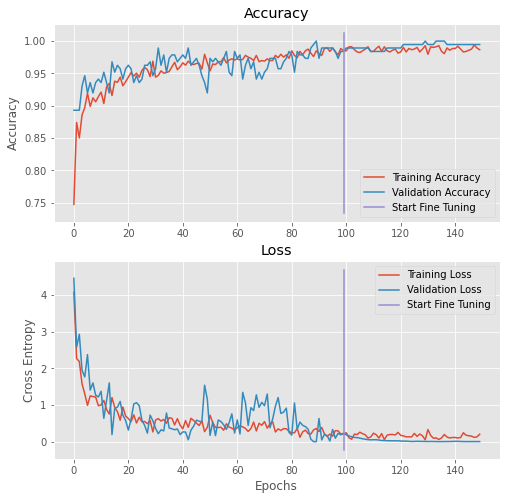

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.7097 - accuracy: 0.9531

2/5 [===========>..................] - ETA: 2s - loss: 1.9294 - accuracy: 0.9531

3/5 [=================>............] - ETA: 2s - loss: 1.3938 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 1.2192 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.9647

5/5 [==============================] - 6s 1s/step - loss: 1.1633 - accuracy: 0.9647


[1.1633145809173584, 0.9646643400192261]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9646643109540636
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.97       402

    accuracy                           0.96       566
   macro avg       0.95      0.96      0.96       566
weighted avg       0.97      0.96      0.96       566



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

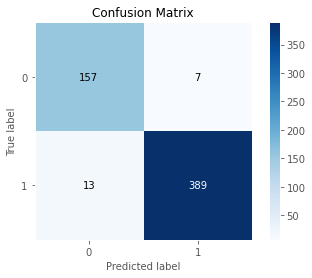

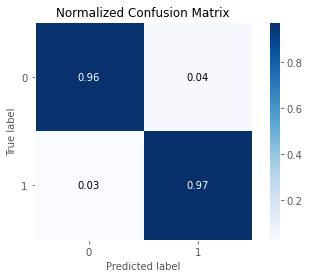

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       164
           1       0.98      0.97      0.97       402

    accuracy                           0.96       566
   macro avg       0.95      0.96      0.96       566
weighted avg       0.97      0.96      0.96       566

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.96      0.97      0.94      0.96      0.93       164
          1       0.98      0.97      0.96      0.97      0.96      0.93       402

avg / total       0.97      0.96      0.96      0.96      0.96      0.93       566

